In [74]:
%pip install pandas
%pip install matplotlib
%pip install codebleu
%pip install tree_sitter_python==0.21
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from codebleu import calc_codebleu


### COMMON METHODS

In [76]:
def create_question_id_map(file):
    df = pd.read_json(file)
    question_id_map = {row['question_id']: row for _, row in df.iterrows()}
    return question_id_map

REFERENCE_FILE_RT_EFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_eff_submissions.json"
REFERENCE_FILE_RT_INEFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json"
MASTER_MAP = create_question_id_map("/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples.json")

In [81]:

def get_normalized_df(file):
    df = pd.read_json(file)
    tmp_df = pd.json_normalize(df['submission_details'])
    df = df.drop(columns=['submission_details']).join(tmp_df, rsuffix='_details')
    return df

def get_diff(codegen_file: str, reference_file: str):
    codegen_df = get_normalized_df(codegen_file)
    reference_df = get_normalized_df(reference_file)

    # Filter accepted solutions
    codegen_accepted = codegen_df[codegen_df['status.description'] == 'Accepted']
    reference_accepted = reference_df[reference_df['status.description'] == 'Accepted']

    # Initialize lists to store results
    rt_faster_solutions = []
    more_memory_efficient_solutions = []

    # Compare performance for each question
    for question_id in codegen_accepted['question_id'].unique():
        codegen_solution = codegen_accepted[codegen_accepted['question_id'] == question_id]
        reference_solution = reference_accepted[reference_accepted['question_id'] == question_id]
        
        if not codegen_solution.empty and not reference_solution.empty:
            master_row = MASTER_MAP.get(question_id)
            codegen_runtime = codegen_solution['time'].values[0]
            reference_runtime = reference_solution['time'].values[0]
            codegen_memory = codegen_solution['memory'].values[0]
            reference_memory = reference_solution['memory'].values[0]
            topics = master_row['topics'][0]
            difficulty = master_row['difficulty']
            
            # Determine which solution is faster
            if codegen_runtime < reference_runtime:
                rt_faster_solutions.append((
                    question_id, 
                    'codegen',
                    codegen_runtime, 
                    reference_runtime, 
                    topics,
                    difficulty
                ))
            else:
                rt_faster_solutions.append((
                    question_id, 
                    'reference', 
                    codegen_runtime, 
                    reference_runtime,
                    topics,
                    difficulty
                ))
            
            # Determine which solution is more memory efficient
            if codegen_memory < reference_memory:
                more_memory_efficient_solutions.append((
                    question_id, 
                    'codegen', 
                    codegen_memory, 
                    reference_memory,
                    topics,
                    difficulty
                ))
            else:
                more_memory_efficient_solutions.append((
                    question_id, 
                    'reference', 
                    codegen_memory, 
                    reference_memory,
                    topics,
                    difficulty
                ))
    
    rt_faster_solutions_df = pd.DataFrame(rt_faster_solutions, columns=['question_id', 'faster_solution', 'codegen_runtime', 'reference_runtime','topics','difficulty'])
    more_memory_efficient_solutions_df = pd.DataFrame(more_memory_efficient_solutions, columns=['question_id', 'more_memory_efficient_solution', 'codegen_memory', 'reference_memory','topics','difficulty'])
    
    percentage_runtime_faster_solutions = ((rt_faster_solutions_df["faster_solution"] == "codegen").sum() / len(rt_faster_solutions)) * 100
    percentage_memory_faster_solutions = ((more_memory_efficient_solutions_df["more_memory_efficient_solution"] == "codegen").sum() / len(more_memory_efficient_solutions)) * 100
    
    # Categorize by topics and difficulty
    categorized_rt_faster_solutions_by_topics = rt_faster_solutions_df.groupby(['topics']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_runtime_faster_solutions'})
    categorized_rt_faster_solutions_by_difficulty = rt_faster_solutions_df.groupby(['difficulty']).apply(lambda x: (x['faster_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_runtime_faster_solutions'})
    categorized_memory_faster_solutions_by_topics = more_memory_efficient_solutions_df.groupby(['topics']).apply(lambda x: (x['more_memory_efficient_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_memory_faster_solutions'})
    categorized_memory_faster_solutions_by_difficulty = more_memory_efficient_solutions_df.groupby(['difficulty']).apply(lambda x: (x['more_memory_efficient_solution'] == 'codegen').sum() / len(x) * 100).reset_index().rename(columns={0: 'percentage_memory_faster_solutions'})
    
    #TODO add code similarity metrics
    return {
        "rt_faster_solutions_df": rt_faster_solutions_df,
        "more_memory_efficient_solutions_df": more_memory_efficient_solutions_df,
        "percentage_runtime_faster_solutions": percentage_runtime_faster_solutions,
        "percentage_memory_faster_solutions": percentage_memory_faster_solutions,
        "categorized_rt_faster_solutions_by_topics": categorized_rt_faster_solutions_by_topics,
        "categorized_rt_faster_solutions_by_difficulty": categorized_rt_faster_solutions_by_difficulty,
        "categorized_memory_faster_solutions_by_topics": categorized_memory_faster_solutions_by_topics,
        "categorized_memory_faster_solutions_by_difficulty": categorized_memory_faster_solutions_by_difficulty
    }

def get_submission_status_charts(df: pd.DataFrame, title: str = 'Distribution of Status Descriptions'):
    status_counts = df['status.description'].value_counts()
    fig = px.pie(values=status_counts.values, names=status_counts.index, title=title)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

def analyze_runtime_errors(df, threshold=1):
    # Define common Python errors
    python_errors = [
        "SyntaxError", "IndentationError", "TypeError", "NameError", "IndexError", "KeyError",
        "AttributeError", "ValueError", "ImportError", "ModuleNotFoundError", "ZeroDivisionError",
        "FileNotFoundError", "IOError", "EOFError", "RuntimeError", "RecursionError",
        "NotImplementedError", "AssertionError", "MemoryError", "OverflowError",
        "StopIteration", "UnboundLocalError", "PermissionError", "TimeoutError"
    ]

    # Filter runtime errors
    runtime_errors = df[df['status.description'] == 'Runtime Error (NZEC)']
    pd.set_option('display.max_colwidth', None)
    runtime_errors = runtime_errors[["question_id", "title", "stderr"]]

    # Count occurrences of each error
    error_counts = {error: runtime_errors['stderr'].str.contains(rf"\b{error}\b", na=False).sum() for error in python_errors}

    # Convert error counts into a DataFrame
    error_df = pd.DataFrame(list(error_counts.items()), columns=["Error Type", "Count"])
    error_df = error_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

    # Categorize errors: keep major ones, group smaller ones as "Others"
    filtered_errors = {err: count for err, count in error_counts.items() if count > threshold}
    others_count = sum(count for _, count in error_counts.items() if count <= threshold)

    # Add "Others" category if applicable
    if others_count > 0:
        filtered_errors["Others"] = others_count

    # Plot pie chart
    fig = go.Figure(data=[go.Pie(labels=list(filtered_errors.keys()), values=list(filtered_errors.values()), textinfo='label+percent', insidetextorientation='radial')])
    fig.update_layout(title_text="Distribution of Python Errors in stderr")
    fig.show()

    # Beautify the table
    table_fig = go.Figure(data=[go.Table(
        header=dict(values=list(error_df.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[error_df['Error Type'], error_df['Count']],
                   fill_color='lavender',
                   align='left'))
    ])
    table_fig.update_layout(title_text="Error Counts Table")
    table_fig.show()

    return error_df

## ANALYSIS FOR METHODOLOGY-1 ( VANILLA PROMPTING )

### LLAMA ANALYSIS

In [78]:
llama_results_1 = get_normalized_df("/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_llama_codegen_submissions.json")
get_submission_status_charts(llama_results_1)
analyze_runtime_errors(llama_results_1)

,Error Type,Count
0,TypeError,12
1,NameError,6
2,AttributeError,6
3,SyntaxError,4
4,IndexError,4
5,ImportError,4
6,ModuleNotFoundError,4
7,UnboundLocalError,3
8,IndentationError,2
9,RecursionError,2


In [79]:
llama_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1,REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1,REFERENCE_FILE_RT_INEFF)


print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Efficient Reference):")
print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Inefficient Reference):")
print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 56.71641791044776
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 96.05263157894737

Categorized Runtime Faster Solutions by Difficulty (Efficient Reference):
difficulty      None
      Easy 35.714286
      Hard 65.000000
    Medium 78.947368

Categorized Runtime Faster Solutions by Difficulty (Inefficient Reference):
difficulty       None
      Easy  93.103448
      Hard 100.000000
    Medium  96.000000

Categorized Runtime Faster Solutions by Topics (Efficient Reference):
             topics       None
              array  62.500000
 depth-first-search 100.000000
 divide-and-conquer 100.000000
dynamic-programming   0.000000
         hash-table  56.250000
               math  36.363636
             string  70.000000
               tree 100.000000
       two-pointers   0.000000

Categorized Runtime Faster Solutions by Topics (Inefficient Reference):
             topics       

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:80: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:81: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

In [82]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by difficulty into DataFrames
difficulty_eff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

difficulty_ineff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same difficulty levels
difficulty_levels = sorted(set(difficulty_eff['Difficulty']).union(set(difficulty_ineff['Difficulty'])))
difficulty_eff = difficulty_eff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()
difficulty_ineff = difficulty_ineff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Difficulty (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=difficulty_eff['Difficulty'],
    y=difficulty_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=difficulty_ineff['Difficulty'],
    y=difficulty_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Difficulty',
    xaxis_title='Difficulty Level',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=difficulty_levels),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Difficulty ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Difficulty', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        difficulty_eff['Difficulty'],
        difficulty_eff['Percentage'],
        difficulty_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Difficulty")
table_fig.show()

# # ---- Print Categorized Runtime Faster Solutions by Topics ----
# print("\nCategorized Runtime Faster Solutions by Topics (Efficient Reference):")
# print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

# print("\nCategorized Runtime Faster Solutions by Topics (Inefficient Reference):")
# print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/3565812118.py:80: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/3565812118.py:81: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/3565812118.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 56.71641791044776
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 96.05263157894737


In [46]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by topics into DataFrames
topics_eff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

topics_ineff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same topics
topics = sorted(set(topics_eff['Topic']).union(set(topics_ineff['Topic'])))
topics_eff = topics_eff.set_index('Topic').reindex(topics).fillna(0).reset_index()
topics_ineff = topics_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Topics (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=topics_eff['Topic'],
    y=topics_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_ineff['Topic'],
    y=topics_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Topics',
    xaxis_title='Topic',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=topics),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Topics ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Topic', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        topics_eff['Topic'],
        topics_eff['Percentage'],
        topics_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Topics")
table_fig.show()

# # ---- Print Categorized Runtime Faster Solutions by Difficulty ----
# print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
# print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

# print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
# print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 56.71641791044776
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 96.05263157894737


/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:83: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:84: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

## ANALYSIS FOR METHODOLOGY-2 ( REASONING BASED )

### LLAMA ANALYSIS

In [49]:
llama_results_2 = get_normalized_df("/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_llama_codegen_submissions.json")
get_submission_status_charts(llama_results_2)
analyze_runtime_errors(llama_results_2)

,Error Type,Count
0,TypeError,7
1,ImportError,4
2,ModuleNotFoundError,4
3,AttributeError,1
4,NameError,0
5,IndexError,0
6,IndentationError,0
7,SyntaxError,0
8,ValueError,0
9,KeyError,0


In [50]:
llama_codegen_file_2 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_2,REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_2,REFERENCE_FILE_RT_INEFF)


print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Efficient Reference):")
print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

print("\nCategorized Runtime Faster Solutions by Topics (Inefficient Reference):")
print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 34.862385321100916
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 72.26890756302521

Categorized Runtime Faster Solutions by Difficulty (Efficient Reference):
difficulty  percentage_runtime_faster_solutions
      Easy                            32.432432
      Hard                            25.000000
    Medium                            45.000000

Categorized Runtime Faster Solutions by Difficulty (Inefficient Reference):
difficulty  percentage_runtime_faster_solutions
      Easy                            65.789474
      Hard                            67.647059
    Medium                            80.851064

Categorized Runtime Faster Solutions by Topics (Efficient Reference):
             topics  percentage_runtime_faster_solutions
              array                            40.000000
       backtracking                            50.000000
   bit-manipulation      

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:83: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:84: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

In [51]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by difficulty into DataFrames
difficulty_eff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

difficulty_ineff = pd.DataFrame(
    {'Difficulty': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['difficulty']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same difficulty levels
difficulty_levels = sorted(set(difficulty_eff['Difficulty']).union(set(difficulty_ineff['Difficulty'])))
difficulty_eff = difficulty_eff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()
difficulty_ineff = difficulty_ineff.set_index('Difficulty').reindex(difficulty_levels).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Difficulty (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=difficulty_eff['Difficulty'],
    y=difficulty_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=difficulty_ineff['Difficulty'],
    y=difficulty_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Difficulty',
    xaxis_title='Difficulty Level',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=difficulty_levels),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Difficulty ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Difficulty', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        difficulty_eff['Difficulty'],
        difficulty_eff['Percentage'],
        difficulty_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Difficulty")
table_fig.show()

# # ---- Print Categorized Runtime Faster Solutions by Topics ----
# print("\nCategorized Runtime Faster Solutions by Topics (Efficient Reference):")
# print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

# print("\nCategorized Runtime Faster Solutions by Topics (Inefficient Reference):")
# print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 34.862385321100916
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 72.26890756302521


/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:83: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:84: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

In [52]:
import pandas as pd
import plotly.graph_objects as go

llama_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_llama_codegen_submissions.json"
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Print percentage of generated code faster than reference solutions
print("Percentage of Generated Code Faster than Runtime Efficient Reference Solution:", llama_diff_with_rt_eff["percentage_runtime_faster_solutions"])
print("Percentage of Generated Code Faster than Runtime Inefficient Reference Solution:", llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"])

# Convert categorized runtime faster solutions by topics into DataFrames
topics_eff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

topics_ineff = pd.DataFrame(
    {'Topic': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['topics']),
     'Percentage': list(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_topics"]['percentage_runtime_faster_solutions'])}
)

# Ensure both DataFrames have the same topics
topics = sorted(set(topics_eff['Topic']).union(set(topics_ineff['Topic'])))
topics_eff = topics_eff.set_index('Topic').reindex(topics).fillna(0).reset_index()
topics_ineff = topics_ineff.set_index('Topic').reindex(topics).fillna(0).reset_index()

# ---- Bar Chart: Runtime Faster Solutions by Topics (Grouped) ----
fig = go.Figure()

# Add bars for Efficient Reference
fig.add_trace(go.Bar(
    x=topics_eff['Topic'],
    y=topics_eff['Percentage'],
    name='Efficient Reference',
    marker_color='blue'
))

# Add bars for Inefficient Reference
fig.add_trace(go.Bar(
    x=topics_ineff['Topic'],
    y=topics_ineff['Percentage'],
    name='Inefficient Reference',
    marker_color='red'
))

# Update layout to group the bars and show a legend
fig.update_layout(
    barmode='group',
    title='Categorized Runtime Faster Solutions by Topics',
    xaxis_title='Topic',
    yaxis_title='Percentage of Runtime Faster Solutions',
    xaxis=dict(tickmode='array', tickvals=topics),
    legend_title="References"
)

# Show the plot
fig.show()

# ---- Table: Categorized Runtime Faster Solutions by Topics ----
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['Topic', 'Efficient Reference (%)', 'Inefficient Reference (%)'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[
        topics_eff['Topic'],
        topics_eff['Percentage'],
        topics_ineff['Percentage']
    ],
    fill_color='lavender',
    align='left'))
])

table_fig.update_layout(title_text="Categorized Runtime Faster Solutions by Topics")
table_fig.show()

# # ---- Print Categorized Runtime Faster Solutions by Difficulty ----
# print("\nCategorized Runtime Faster Solutions by Difficulty (Efficient Reference):")
# print(llama_diff_with_rt_eff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

# print("\nCategorized Runtime Faster Solutions by Difficulty (Inefficient Reference):")
# print(llama_diff_with_rt_ineff["categorized_rt_faster_solutions_by_difficulty"].to_string(index=False))

Percentage of Generated Code Faster than Runtime Efficient Reference Solution: 34.862385321100916
Percentage of Generated Code Faster than Runtime Inefficient Reference Solution: 72.26890756302521


/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:83: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_84770/3757835152.py:84: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

# Comparing prompting methods

In [85]:
import pandas as pd
import plotly.express as px

# Load the datasets for different prompting methods of Llama
llama_vanilla_file = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_llama_codegen_submissions.json"
llama_reasoning_file = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_llama_codegen_submissions.json"
REFERENCE_FILE_RT_EFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_eff_submissions.json"
REFERENCE_FILE_RT_INEFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json"

# Get differences for Llama Vanilla Prompting
llama_vanilla_diff_with_rt_eff = get_diff(llama_vanilla_file, REFERENCE_FILE_RT_EFF)
llama_vanilla_diff_with_rt_ineff = get_diff(llama_vanilla_file, REFERENCE_FILE_RT_INEFF)

# Get differences for Llama Reasoning-Based Prompting
llama_reasoning_diff_with_rt_eff = get_diff(llama_reasoning_file, REFERENCE_FILE_RT_EFF)
llama_reasoning_diff_with_rt_ineff = get_diff(llama_reasoning_file, REFERENCE_FILE_RT_INEFF)

# Calculate overall acceptance rates
llama_vanilla_acceptance_eff = llama_vanilla_diff_with_rt_eff["percentage_runtime_faster_solutions"]
llama_vanilla_acceptance_ineff = llama_vanilla_diff_with_rt_ineff["percentage_runtime_faster_solutions"]
llama_reasoning_acceptance_eff = llama_reasoning_diff_with_rt_eff["percentage_runtime_faster_solutions"]
llama_reasoning_acceptance_ineff = llama_reasoning_diff_with_rt_ineff["percentage_runtime_faster_solutions"]

# Create DataFrame for comparison
acceptance_df = pd.DataFrame({
    'Metric': ['Efficient Reference', 'Inefficient Reference'],
    'Llama Vanilla': [llama_vanilla_acceptance_eff, llama_vanilla_acceptance_ineff],
    'Llama Reasoning': [llama_reasoning_acceptance_eff, llama_reasoning_acceptance_ineff]
}).melt(id_vars='Metric', var_name='Prompting Method', value_name='Percentage')

# Bar chart for acceptance comparison
fig = px.bar(acceptance_df, x='Metric', y='Percentage', color='Prompting Method', barmode='group', title='Acceptance Rate Comparison for Llama Prompting Methods')
fig.show()

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/3565812118.py:80: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/3565812118.py:81: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/3565812118.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

In [89]:
# Box plot for runtime with respect to efficient reference
fig = px.box(combined_df, x='Prompting Method', y='time', color='Prompting Method', title='Runtime Distribution with Respect to Efficient Reference', points='all')
fig.show()

# Box plot for runtime with respect to inefficient reference
fig = px.box(combined_df, x='Prompting Method', y='time', color='Prompting Method', title='Runtime Distribution with Respect to Inefficient Reference', points='all')
fig.show()

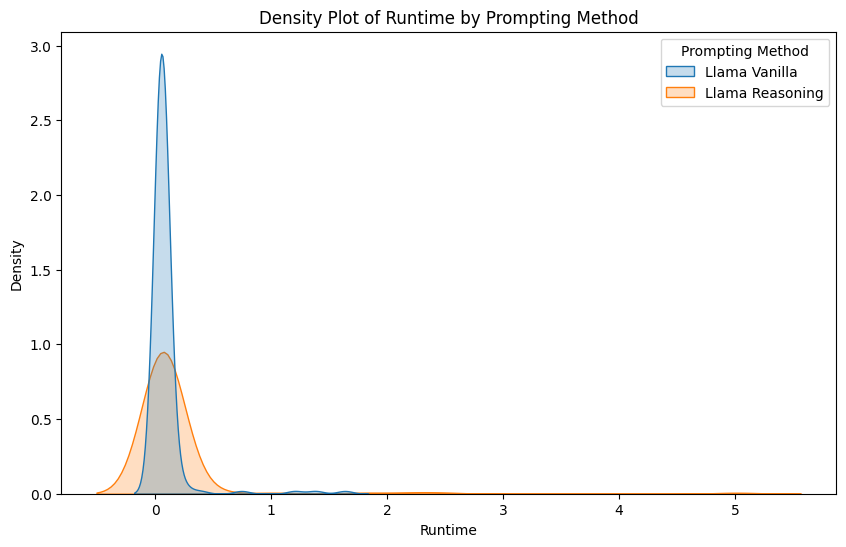

In [95]:
# Convert 'time' column to numeric, coercing errors to NaN
combined_df['time'] = pd.to_numeric(combined_df['time'], errors='coerce')

# Drop rows with NaN values in 'time' column
combined_df = combined_df.dropna(subset=['time'])

# Density plot for runtime
plt.figure(figsize=(10, 6))
sns.kdeplot(data=combined_df, x='time', hue='Prompting Method', fill=True)
plt.title('Density Plot of Runtime by Prompting Method')
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

# CDF for runtime
fig = px.ecdf(combined_df, x='time', color='Prompting Method', title='CDF of Runtime by Prompting Method')
fig.show()

# Results for RQ 3 - Comparing MetaLLama vs Gemini 2.0 Flash

Results for Vanilla prompting in both models

In [16]:
# Load the datasets
llama_results_1 = get_normalized_df("/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_llama_codegen_submissions.json")
gemini_results_1 = get_normalized_df("/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_gemini_codegen_submissions.json")

# Combine submission status charts
def get_combined_submission_status_charts(df1: pd.DataFrame, df2: pd.DataFrame, labels: list, title: str = 'Distribution of Status Descriptions'):
    status_counts_1 = df1['status.description'].value_counts()
    status_counts_2 = df2['status.description'].value_counts()

    combined_df = pd.DataFrame({
        'Status': status_counts_1.index,
        labels[0]: status_counts_1.values,
        labels[1]: status_counts_2.values
    }).melt(id_vars='Status', var_name='Dataset', value_name='Count')

    fig = px.bar(combined_df, x='Status', y='Count', color='Dataset', barmode='group', title=title)
    fig.show()

get_combined_submission_status_charts(llama_results_1, gemini_results_1, ['Llama', 'Gemini'])

# Combine runtime error analysis
def get_combined_runtime_error_analysis(df1: pd.DataFrame, df2: pd.DataFrame, labels: list):
    python_errors = [
        "SyntaxError", "IndentationError", "TypeError", "NameError", "IndexError", "KeyError",
        "AttributeError", "ValueError", "ImportError", "ModuleNotFoundError", "ZeroDivisionError",
        "FileNotFoundError", "IOError", "EOFError", "RuntimeError", "RecursionError",
        "NotImplementedError", "AssertionError", "MemoryError", "OverflowError",
        "StopIteration", "UnboundLocalError", "PermissionError", "TimeoutError"
    ]

    runtime_errors_1 = df1[df1['status.description'] == 'Runtime Error (NZEC)']
    runtime_errors_2 = df2[df2['status.description'] == 'Runtime Error (NZEC)']

    error_counts_1 = {error: runtime_errors_1['stderr'].str.contains(rf"\b{error}\b", na=False).sum() for error in python_errors}
    error_counts_2 = {error: runtime_errors_2['stderr'].str.contains(rf"\b{error}\b", na=False).sum() for error in python_errors}

    combined_error_df = pd.DataFrame({
        'Error Type': list(error_counts_1.keys()),
        labels[0]: list(error_counts_1.values()),
        labels[1]: list(error_counts_2.values())
    }).melt(id_vars='Error Type', var_name='Dataset', value_name='Count')

    fig = px.bar(combined_error_df, x='Error Type', y='Count', color='Dataset', barmode='group', title='Distribution of Python Errors in stderr')
    fig.show()

get_combined_runtime_error_analysis(llama_results_1, gemini_results_1, ['Llama', 'Gemini'])

In [11]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [68]:
import pandas as pd
import plotly.express as px

# Load the datasets
llama_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_llama_codegen_submissions.json"
gemini_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_gemini_codegen_submissions.json"
REFERENCE_FILE_RT_EFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_eff_submissions.json"
REFERENCE_FILE_RT_INEFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P1/balanced_samples_reference_rt_ineff_submissions.json"

# Get differences for Llama
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Get differences for Gemini
gemini_diff_with_rt_eff = get_diff(gemini_codegen_file_1, REFERENCE_FILE_RT_EFF)
gemini_diff_with_rt_ineff = get_diff(gemini_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Calculate overall acceptance rates
llama_acceptance_eff = llama_diff_with_rt_eff["percentage_runtime_faster_solutions"]
llama_acceptance_ineff = llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"]
gemini_acceptance_eff = gemini_diff_with_rt_eff["percentage_runtime_faster_solutions"]
gemini_acceptance_ineff = gemini_diff_with_rt_ineff["percentage_runtime_faster_solutions"]

# Create DataFrame for comparison
acceptance_df = pd.DataFrame({
    'Metric': ['Efficient Reference', 'Inefficient Reference'],
    'Llama': [llama_acceptance_eff, llama_acceptance_ineff],
    'Gemini': [gemini_acceptance_eff, gemini_acceptance_ineff]
}).melt(id_vars='Metric', var_name='Dataset', value_name='Percentage')

# Bar chart for acceptance comparison
fig = px.bar(acceptance_df, x='Metric', y='Percentage', color='Dataset', barmode='group', title='Acceptance Rate Comparison')
fig.show()

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:80: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:81: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

In [69]:
# Combine the datasets for comparison
llama_results_1 = get_normalized_df(llama_codegen_file_1)
gemini_results_1 = get_normalized_df(gemini_codegen_file_1)
llama_results_1['Dataset'] = 'Llama'
gemini_results_1['Dataset'] = 'Gemini'
combined_df = pd.concat([llama_results_1, gemini_results_1])

# Box plot for runtime
fig = px.box(combined_df, x='Dataset', y='time', points='all', title='Runtime Distribution by Dataset')
fig.show()

Results after Reasoning Based Prompting in Both Models

In [70]:
import pandas as pd
import plotly.express as px

# Load the datasets
llama_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_llama_codegen_submissions.json"
gemini_codegen_file_1 = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_gemini_codegen_submissions.json"
REFERENCE_FILE_RT_EFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_reference_rt_eff_submissions.json"
REFERENCE_FILE_RT_INEFF = "/Users/bisman/Documents/ECS 260/Project github/CodeRefineAI/dataset/P2/balanced_samples_reference_rt_ineff_submissions.json"

# Get differences for Llama
llama_diff_with_rt_eff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_EFF)
llama_diff_with_rt_ineff = get_diff(llama_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Get differences for Gemini
gemini_diff_with_rt_eff = get_diff(gemini_codegen_file_1, REFERENCE_FILE_RT_EFF)
gemini_diff_with_rt_ineff = get_diff(gemini_codegen_file_1, REFERENCE_FILE_RT_INEFF)

# Calculate overall acceptance rates
llama_acceptance_eff = llama_diff_with_rt_eff["percentage_runtime_faster_solutions"]
llama_acceptance_ineff = llama_diff_with_rt_ineff["percentage_runtime_faster_solutions"]
gemini_acceptance_eff = gemini_diff_with_rt_eff["percentage_runtime_faster_solutions"]
gemini_acceptance_ineff = gemini_diff_with_rt_ineff["percentage_runtime_faster_solutions"]

# Create DataFrame for comparison
acceptance_df = pd.DataFrame({
    'Metric': ['Efficient Reference', 'Inefficient Reference'],
    'Llama': [llama_acceptance_eff, llama_acceptance_ineff],
    'Gemini': [gemini_acceptance_eff, gemini_acceptance_ineff]
}).melt(id_vars='Metric', var_name='Dataset', value_name='Percentage')

# Bar chart for acceptance comparison
fig = px.bar(acceptance_df, x='Metric', y='Percentage', color='Dataset', barmode='group', title='Acceptance Rate Comparison')
fig.show()

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:80: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:81: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/48/pk6bblsj0dl6x95dzf05c5bm0000gn/T/ipykernel_91794/148245144.py:82: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping col

In [71]:
# Combine the datasets for comparison
llama_results_1 = get_normalized_df(llama_codegen_file_1)
gemini_results_1 = get_normalized_df(gemini_codegen_file_1)
llama_results_1['Dataset'] = 'Llama'
gemini_results_1['Dataset'] = 'Gemini'
combined_df = pd.concat([llama_results_1, gemini_results_1])

# Box plot for runtime
fig = px.box(combined_df, x='Dataset', y='time', points='all', title='Runtime Distribution by Dataset')
fig.show()